In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, hamming_loss, jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



In [82]:
embeddings = np.load("chest-xray14_embeddings.npy")
annotation = pd.read_csv('Data_Entry_2017.csv')
print(annotation)

             Image Index          Finding Labels  Follow-up #  Patient ID  \
0       00000001_000.png            Cardiomegaly            0           1   
1       00000001_001.png  Cardiomegaly|Emphysema            1           1   
2       00000001_002.png   Cardiomegaly|Effusion            2           1   
3       00000002_000.png              No Finding            0           2   
4       00000003_000.png                  Hernia            0           3   
...                  ...                     ...          ...         ...   
112115  00030801_001.png          Mass|Pneumonia            1       30801   
112116  00030802_000.png              No Finding            0       30802   
112117  00030803_000.png              No Finding            0       30803   
112118  00030804_000.png              No Finding            0       30804   
112119  00030805_000.png              No Finding            0       30805   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
0 

In [83]:

file_path = "selected_png_list.txt"
ids = []

with open(file_path, 'r') as file:
    for line in file:
        full_path = line.strip()  
        filename = os.path.basename(full_path)
        ids.append(filename)

label_dict = annotation.set_index('Image Index')['Finding Labels'].to_dict()

labels = []
for id in ids:
    if label_dict[id] == 'No Finding':
        labels.append(0)
    else:
        labels.append(1)


In [84]:
# Balance classes for labels and embeddings.
bal_embeddings = []
bal_labels = []

count_pos = 0
count_neg = 0
index = 0
while count_pos < 400:
    lab = labels[index]
    if lab == 1:
        bal_embeddings.append(embeddings[index])
        bal_labels.append(lab)
        count_pos += 1
    
    index += 1

index = 0
while count_neg < 400:
    lab = labels[index]
    if lab == 0:
        bal_embeddings.append(embeddings[index])
        bal_labels.append(lab)
        count_neg += 1

    index += 1



X_train, X_test, y_train, y_test = train_test_split(bal_embeddings, bal_labels, test_size=0.2, random_state=42)

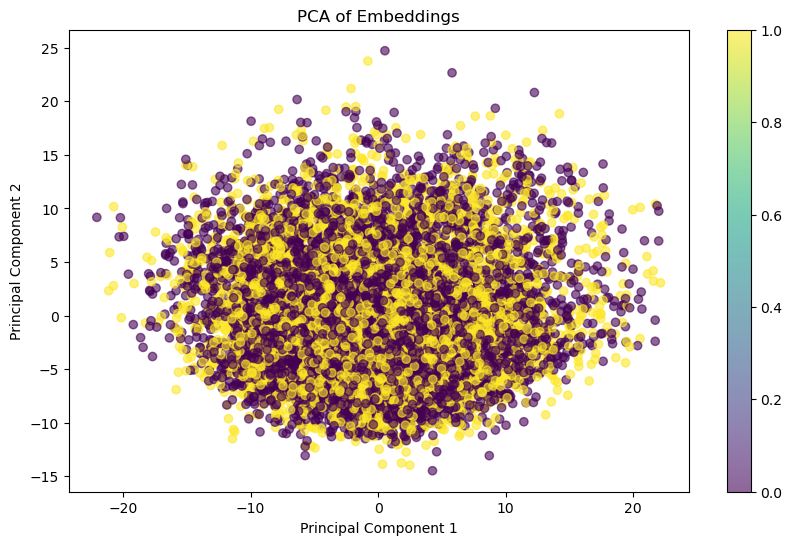

In [85]:

scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Initialize PCA, here we are reducing to 2 dimensions for easy visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(embeddings_scaled)

# Plotting the results
def plot_pca(principal_components, labels):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.title('PCA of Embeddings')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(scatter)
    plt.show()

plot_pca(principal_components, labels)

## Binary Classification
Instead of one hot encoding each possible outomce and doing a one vs rest logistic classifier, we want to do binary classification if there is a 
disease outcomne or not. This should theoretically improve the accuracy of the model.


# Hand Iplementation

## Logistic Regression
1. Implement Sigmoid function - hard assignment of 0 to 1.
2. Implement a loss function.
3. Implement gradient descent.
4. Prediction function.

In [77]:
# Implement a sigmoid function.

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


# Compute cross entropy loss
def compute_loss(y, y_hat):
    # Ensure that both y and y_hat are NumPy arrays
    y = np.array(y)
    y_hat = np.array(y_hat)

    # Avoid division by zero and log domain issues
    epsilon = 1e-15
    y_hat = np.clip(y_hat, epsilon, 1 - epsilon)
    
    # Compute the binary cross-entropy loss
    loss = -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
    return loss


# Predict function
def predict(X, weights, bias):
    z = np.dot(X, weights) + bias
    y_pred = sigmoid(z)
    return y_pred.round()  # returns class labels based on threshold of 0.5


# Implement gradient descent.
def grad_desc(X, y, num_iterations, learning_rate):
    # Find the shape of X
    X = np.array(X)
    
    m, n = X.shape

    # Set the parameters equal to zero.
    params = np.zeros(n)

    # Set the bias.
    bias = 0

    # Set weights.
    weights = np.zeros(n)

    for i in range(num_iterations):


        # Do the linear combination of the weights plus biases.
        z = np.dot(X, weights) + bias
        # Do the prediction with the current weights.

        predicted = sigmoid(z)
        # Find change in weights. (Calculate the gradient).
        deltaweights = np.dot(X.T, (predicted - y)) / m
        deltabias = np.sum(predicted - y) / m

        # Update the weights and biases.
        weights -= learning_rate*deltaweights
        bias -= learning_rate*deltabias

        loss = compute_loss(y, predicted)
        # Print out every one hundred steps.
        if num_iterations % 100 == 0.0:
            print(f"Step {i}, Loss: {loss}")


    return weights, bias


# Precision, Recall, and F1 Score calculation
def calculate_precision_recall_f1(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)


    TP = np.sum((y_pred == 1) & (y_true == 1))
    FP = np.sum((y_pred == 1) & (y_true == 0))
    FN = np.sum((y_pred == 0) & (y_true == 1))
    
    print(TP, FP, FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1_score


def TestWeightsBiases(X_test, y_test, weights, biases):
    # Make predictions
    predictions = predict(X_test, weights, biases)
    # Evaluate precision, recall, and F1 score
    print(predictions[0:10], y_test[0:10])
    precision, recall, f1_score = calculate_precision_recall_f1(y_test, predictions)
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1_score:.2f}")


In [80]:
weights, biases = grad_desc(X_train, y_train, 1000, 0.5)
TestWeightsBiases(X_test, y_test, weights, biases)

Step 0, Loss: 0.6931471805599453
Step 1, Loss: 0.6931265523138241
Step 2, Loss: 0.6931059622863954
Step 3, Loss: 0.6930854020352414
Step 4, Loss: 0.693064866614274
Step 5, Loss: 0.6930443531205979
Step 6, Loss: 0.6930238598453327
Step 7, Loss: 0.6930033857773766
Step 8, Loss: 0.6929829303134171
Step 9, Loss: 0.692962493088469
Step 10, Loss: 0.6929420738768458
Step 11, Loss: 0.6929216725342885
Step 12, Loss: 0.692901288964148
Step 13, Loss: 0.6928809230976234
Step 14, Loss: 0.6928605748822119
Step 15, Loss: 0.6928402442749612
Step 16, Loss: 0.6928199312385251
Step 17, Loss: 0.6927996357388588
Step 18, Loss: 0.6927793577438719
Step 19, Loss: 0.6927590972226413
Step 20, Loss: 0.6927388541449513
Step 21, Loss: 0.6927186284810245
Step 22, Loss: 0.6926984202013647
Step 23, Loss: 0.6926782292766649
Step 24, Loss: 0.692658055677754
Step 25, Loss: 0.6926378993755641
Step 26, Loss: 0.6926177603411137
Step 27, Loss: 0.6925976385454955
Step 28, Loss: 0.6925775339598708
Step 29, Loss: 0.69255744655